## Visualizing and Obtaining the output

In [1]:
import cv2
import numpy as np

from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

Using TensorFlow backend.


In [2]:
#metrics used when traiing but are not significant, still needed to load the model however 
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
#also needed to load the model
def custom_loss():
    def loss(target, pred):
        a = 0.5
        B = 0.5
        g = 0.5

        ##invert image
        pred_inv = 1 - pred[:,:,:,0]
        target_inv = 1 - target[:,:,:,0]

        ## not inverted
        pred = pred[:,:,:,0]
        target = target[:,:,:,0]

        def intersection (target_b, pred_b , a):
            inter = pred_b * target_b

            PG = K.sum(target_b)
            PD = K.sum((pred_b))
            PGuPD = K.sum(inter)
            DP = PGuPD/(PG + K.epsilon())
            FP = PGuPD/(PD + K.epsilon())
            return (a*DP +(1-a)*FP)


        PMI = intersection(target_inv, pred_inv, a)   
        GMI = intersection(target, pred, B)

        return (1 - (g*(PMI) + (1-g)*GMI))

    return loss

In [10]:
#loading trained model
from tensorflow.keras.models import load_model

model = load_model("Model.h5", custom_objects={'loss': custom_loss(),'precision_m': precision_m,'recall_m':recall_m,'f1_m':f1_m })

In [11]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, None, None, 3 320         input_4[0][0]                    
__________________________________________________________________________________________________
bn1_1 (BatchNormalization)      (None, None, None, 3 128         conv1_1[0][0]                    
__________________________________________________________________________________________________
rel1_1 (ReLU)                   (None, None, None, 3 0           bn1_1[0][0]                      
____________________________________________________________________________________________

## Obtaining Output 

In [7]:
#prep function


## we need to pad to the next createst multiple of 8
def RoundUp(x): 
    return ((x + 7) & (-8)) 
x = 1058
print(RoundUp(x))     

def prep(img):
    a,b = img.shape
    c = RoundUp(a)
    d = RoundUp(b)
    img_prep = np.ones((c,d))*255
    img_prep[0:a,0:b] = img
    img_out = img_prep.reshape(1,c,d,1)
    
    return img_out

1064


In [58]:
for k in range(1,31,1):
    print(k)
    name_l = 'Test_set/Input/img ({}).jpg'. format(k)
    img_1 = cv2.imread(name_l,0)
    a,b = img_1.shape                                            
    
    img = prep(img_1)
        
    inference_image = model.predict(img, batch_size=1)
    inference_image_c = inference_image[:,0:a,0:b,:]
    
    resize = cv2.resize(img_1, (b//2,a//2), interpolation = cv2.INTER_AREA)
    resize = prep(resize)
    inference_image_r = model.predict(resize, batch_size=1)
    inference_image_r = inference_image_r[:,0:a//2,0:b//2,:]
    
    resize_b = cv2.resize(img_1, (b*2,a*2), interpolation = cv2.INTER_AREA)
    resize_b = prep(resize_b)
    inference_image_r_b = model.predict(resize_b, batch_size=1)
    inference_image_r_b = inference_image_r_b [:,0:a*2,0:b*2,:]

    

        
    #sfile = 'Outputs/{}.jpg'.format(k)
    #cv2.imwrite(sfile, ((inference_image_c[0,:,:,:]/inference_image_c[0,:,:,:].max())*255))
    
    #sfile = 'Outputs/{}_r.jpg'.format(k)
    #cv2.imwrite(sfile, ((inference_image_r[0,:,:,:]/inference_image_r[0,:,:,:].max())*255))
    
    sfile = 'Outputs/{}_rb.jpg'.format(k)
    cv2.imwrite(sfile, ((inference_image_r_b[0,:,:,:]*255)))
    
    

25
26
27
28
29
30


## History Visualization

In [59]:
history=np.load('Keras_newloss_noinversion_andinversion_100_reduceddataset_adam.npy',allow_pickle='TRUE').item()

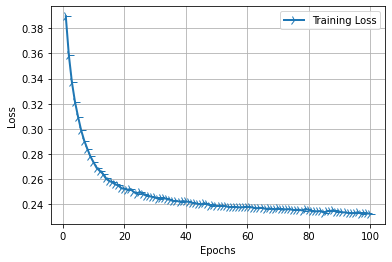

In [61]:
history_dict = history

train_loss = history_dict['loss']#Training loss
#val_loss = history_dict['val_loss']#Validation loss
epochs = range(1,len(train_loss)+1)#Number of epochs

line1 = plt.plot(epochs, train_loss, label = 'Training Loss')
#line2 = plt.plot(epochs, val_loss, label = 'Validation Loss')

plt.setp(line1,linewidth = 2.0, marker = '+', markersize = 10.0)
plt.setp(line1,linewidth = 2.0, marker = '4', markersize = 10.0)

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.grid(True)
plt.legend()

plt.show()